In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from collections import Counter
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

In [51]:
!pip3 install torch==1.8.1+cu101 torchvision==0.9.1+cu101 torchaudio==0.8.1 -f https://download.pytorch.org/whl/torch_stable.html
!pip3 install torchtext==0.9.1
!pip3 install -U spacy 

In [70]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Data Load

- AIHUB번역데이터 : https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=71265

- Transformer 예시코드 : https://ariz1623.tistory.com/304

In [132]:
import json

json_string = '''{
    "id": 1,
    "username": "Bret",
    "email": "Sincere@april.biz",
    "address": {
        "street": "Kulas Light",
        "suite": "Apt. 556",
        "city": "Gwenborough",
        "zipcode": "92998-3874"
    },
    "admin": false,
    "hobbies": null
}'''

json_object = json.loads(json_string)

assert json_object['id'] == 1
assert json_object['email'] == 'Sincere@april.biz'
assert json_object['address']['zipcode'] == '92998-3874'
assert json_object['admin'] is False
assert json_object['hobbies'] is None

In [72]:
with open('/workspace/DBP/data_storage/wontae_kim/스터디/text_data/01.데이터/1.Training/라벨링데이터/일상생활및구어체_영한_train_set.json', 'r') as f:
    data_ = json.load(f)

data_

{'data': [{'sn': 'ECOAR1A00003',
   'data_set': '일상생활및구어체',
   'domain': '해외고객과의채팅',
   'subdomain': '숙박,음식점',
   'en_original': "I'm glad to hear that, and I hope you do consider doing business with us.",
   'en': "I'm glad to hear that, and I hope you do consider doing business with us.",
   'mt': '그 소식을 들으니 기쁩니다. 우리와 거래하는 것을 고려해 보시기 바랍니다.',
   'ko': '그 말을 들으니 기쁘고, 저희와 거래하는 것을 고려해 주셨으면 합니다.',
   'source_language': 'en',
   'target_language': 'ko',
   'word_count_ko': 10.0,
   'word_count_en': 15.0,
   'word_ratio': 0.667,
   'file_name': '해외고객과의채팅_숙박,음식점.xlsx',
   'source': '크라우드 소싱',
   'license': 'open',
   'style': '구어체',
   'included_unknown_words': False,
   'ner': None},
  {'sn': 'ECOAR1A00004',
   'data_set': '일상생활및구어체',
   'domain': '해외고객과의채팅',
   'subdomain': '숙박,음식점',
   'en_original': "I'm definitely thinking about it, but I have some queries to ask you.",
   'en': "I'm definitely thinking about it, but I have some queries to ask you.",
   'mt': '확실히 생각하고 있지만 몇 가지 질문이 있습니다

In [74]:
df = pd.DataFrame()
ko = []
en = []
for i in tqdm(data_['data']):
    en.append(i['en'])
    ko.append(i['ko'])
df['ko'] = ko
df['en'] = en

100%|██████████| 1200307/1200307 [00:01<00:00, 1033457.16it/s]


In [160]:
df.head()

,ko,en
0,"그 말을 들으니 기쁘고, 저희와 거래하는 것을 고려해 주셨으면 합니다.","I'm glad to hear that, and I hope you do consi..."
1,"확실히 생각하고 있습니다만, 몇 가지 여쭤보고 싶은 게 있어요.","I'm definitely thinking about it, but I have s..."
2,오늘날 세계 5가구 중 1가구는 고양이나 개 또는 둘 다를 키우고 있습니다.,"In today's world, one in every five families h..."
3,"그들에게 말하면, 저희가 그 아이들을 돌볼 것입니다.","When you tell them, we'll take care of their c..."
4,"좋아요, 수영은 어떤가요?","OK, how about for swimming?"


In [61]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchtext.legacy.datasets import TranslationDataset, Multi30k
from torchtext.legacy.data import Field, BucketIterator
import numpy as np

import random
import math
import time
from torchtext.legacy import data 
from konlpy.tag import Mecab
from tqdm import tqdm

## Make Tokenizer

In [55]:
# tagger = Mecab(dicpath = '/workspace/DBP/data_storage/wontae_kim/Tokenizer/mecab-ko-dic-2.1.1-20180720')
tagger = Mecab()

### torchtext.legacy.data.Field

`설명` : 필드란 텐서로 표현될 수 있는 텍스트 데이터 타입을 처리한다. 필트를 통해 앞으로 어떤 전처리를 할지 정의해놓을 수 있다.

```python

from torchtext.legacy import data 

data.Field(sequential=True,
			use_vocab=True,
            tokenize=str.split,
            lower=True,
            batch_first=True,
            fix_length=20)
```
`sequential` : 순차 데이터 여부. False이면 토큰화가 적용되지 않음. (default: True) <br>
`use_vocab` : Vocab 개체 사용 여부. False인 경우 이 필드의 데이터는 이미 숫자여야 함. (default: True) <br>
`tokenize` : 사용될 토큰화 함수 (default: string.split) <br>
`lower` : 영어 데이터 소문자화 (default: False) <br>
`batch_first` : 미니 배치 차원을 맨 앞으로 하여 데이터를 불러올 것인지 여부 (default: False) <br>
`is_target` : target variable 여부 (default: False) <br>
`fix_length` : 최대 허용 길이. 이 길이에 맞춰 패딩(Padding) 작업 진행

In [62]:
def tokenize_kor(text):
    return tagger.morphs(text)

def tokenize_en(text):
    return text.split(' ')

SRC = data.Field(tokenize=tokenize_kor,
                 init_token='<sos>',
                 eos_token='<eos>',
                 batch_first=True,
                 lower=True
                )

TRG = data.Field(tokenize=tokenize_en,
                 init_token='<sos>',
                 eos_token='<eos>',
                 batch_first=True,
                 lower=True
                )

## Data set Generate

In [63]:
from sklearn.model_selection import KFold

df_shuffle = df.sample(frac=1).reset_index(drop=True)
df_ = df_shuffle.iloc[:100000]
kf = KFold(n_splits=5, shuffle=True, random_state=7)

for i, (trn_idx, val_idx) in enumerate(kf.split(df_['ko'])):
    trn = df_.iloc[trn_idx]
    val = df_.iloc[val_idx]

In [64]:
print(f'Train_size : {len(trn):,}')
print(f'Valid_size : {len(val):,}')

Train_size : 80,000
Valid_size : 20,000


In [65]:
trn.to_csv('/workspace/DBP/data_storage/wontae_kim/스터디/text_data/trn.csv',
           sep = ',',
           columns = list(trn.columns),
           index = False
          )

val.to_csv('/workspace/DBP/data_storage/wontae_kim/스터디/text_data/val.csv',
           sep = ',',
           columns = list(val.columns),
           index = False
          )

In [66]:
from torchtext.legacy.data import TabularDataset

train_data, validation_data = TabularDataset.splits(path='/workspace/DBP/data_storage/wontae_kim/스터디/text_data',
                                                    train = 'trn.csv',
                                                    validation = 'val.csv',
                                                    format='csv',
                                                    fields=[('kor', SRC), ('en', TRG)],
                                                    skip_header=True
                                                    )
print(f'Train_set_size : {len(train_data)}')
print(f'Validation_set_size : {len(validation_data)}')

Train_set_size : 80000
Validation_set_size : 20000


In [67]:
print(vars(train_data.examples[33])['kor'])
print(vars(validation_data.examples[33])['en'])

['근육', '을', '키우', '려고', '노력', '중', '이', '야', '.']
["it's", 'also', 'stir-fried', 'with', 'fresh', 'green', 'beans', 'and', 'red', 'peppers.']


## Vocab

### "build_vocab"
토큰화 전처리가 끝나면 각 단어에 고유한 정수를 맵핑해주는 정수 인코딩(Integer enoding) 작업이 필요하다. 그리고 이 전처리를 위해서는 우선 단어 집합을 만들어주어야 한다! 정의한 필드에 .build_vocab()을 사용하여 단어 집합을 생성할 수 있다.

- "< unk >": 인코딩 과정에서 사전에 없는 단어는 전부 이 토큰의 인덱스로 인코딩 (0)
- "< pad >": 패딩(입력 데이터를 배치로 처리하려면, 배치 내 모든 데이터가 같은 사이즈를 가져야 함)(1)
- 필드지정시, 문장의 시작 토큰(init_token)과, 끝의 토큰(eos_token)을 넣으면 3, 4 번으로 할당됨.

[min_freq] = 3, # 단어의 최소 등장 빈도 조건<br>
[max_size] = MAX_VOCAB_SIZE, #단어 집합의 최대 크기 지정<br>
[vectors] = 'fasttext.simple.300d', # 사전 훈련된 임베딩 벡터 (한글 지원)<br>
[unk_init] = torch.Tensor.normal_) # 사전훈련된 단어집합에 없는 단어를 0으로 처리하는 것 방지

In [68]:
SRC.build_vocab(train_data, min_freq=2)
TRG.build_vocab(train_data, min_freq=2)

print(f'len(SRC) : {len(SRC.vocab):,}')
print(f'len(TRG) : {len(TRG.vocab):,}')

len(SRC) : 12,602
len(TRG) : 20,485


## Data Loader

In [294]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 129
device

device(type='cuda')

In [296]:
from torchtext.legacy.data import Iterator

train_iterator = Iterator(dataset=train_data, batch_size = BATCH_SIZE)
valid_iterator = Iterator(dataset=validation_data, batch_size = BATCH_SIZE)

## Multi head Attention
- query 행렬과 key 행렬간의 내적을 계산
- 1번 값에 key 행렬의 차원의 제곱근으로 나눔
- 2번 값에 소프트맥스 함수를 적용해 정규화 진행
- 3번 값에 value 행렬을 곱해 attention 출력

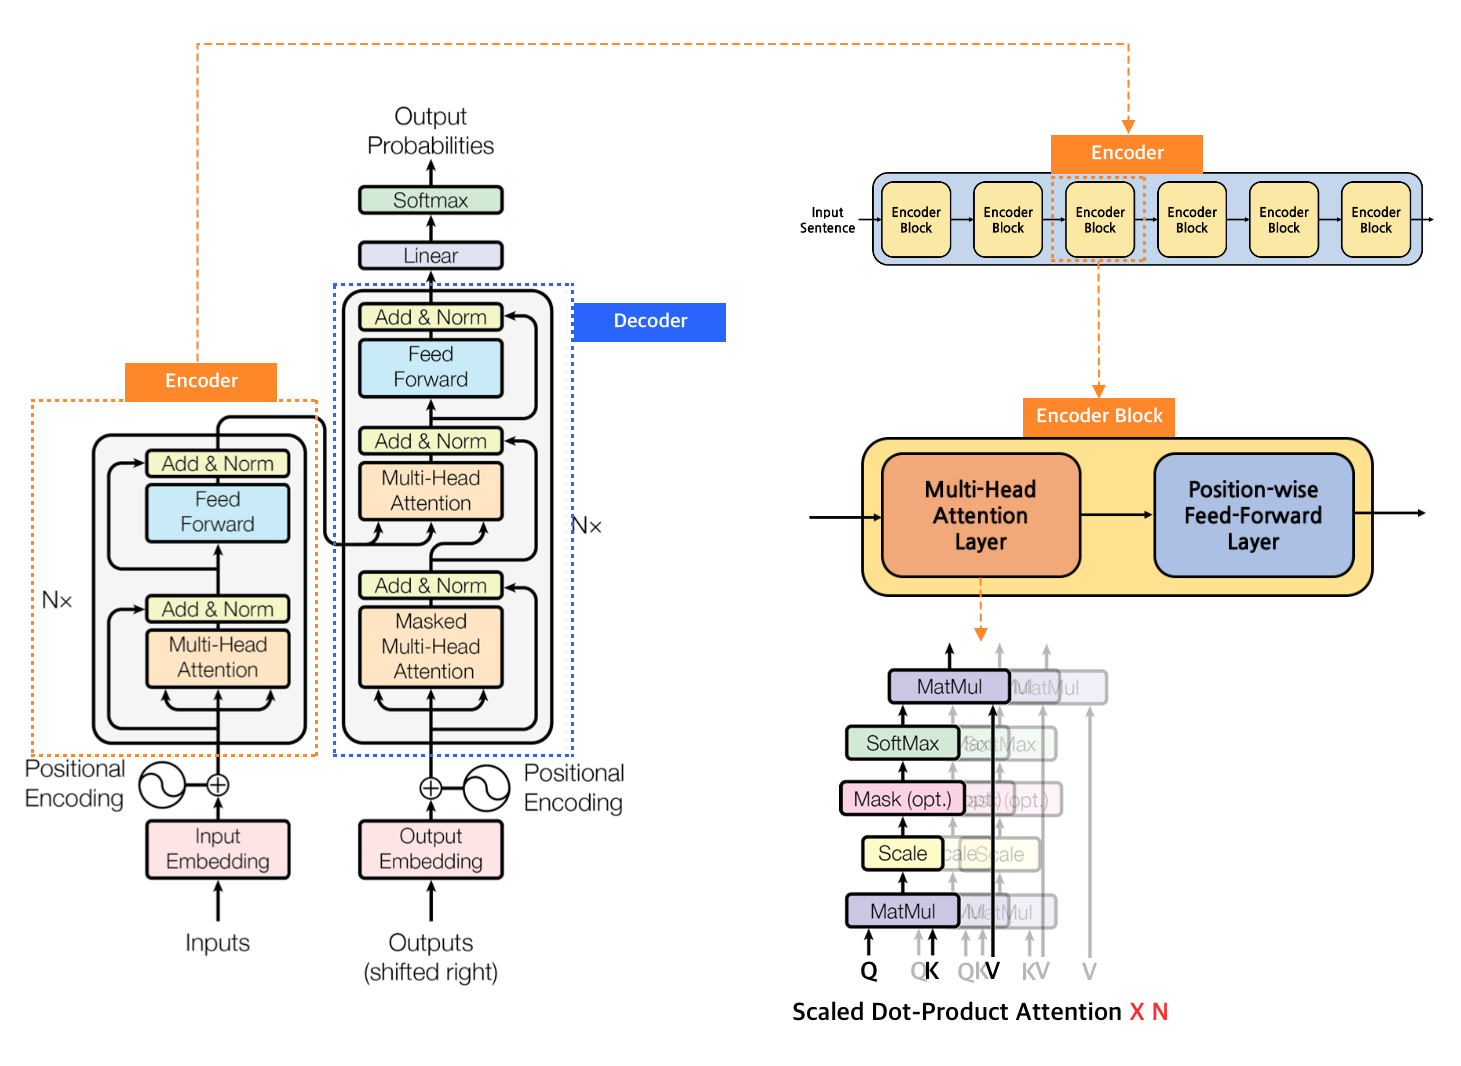

## What is Attention?

우선 Transformer는 input sentence를 넣어서 output sentence를 생성하는 model이다.
- input과 동일한 sentence를 만들어낼수도
- input의 역방향 sentence를 만들수도
- 같은 의미의 다른 언어로 된 Sentence를 만들어낼수도 있다.

이것을 결정하는 것은, train과정에서 target을 어떤 sentence로 정하는가에 따라 달라진다.

쉽게 풀어내면, 'Transformer란 sentence형태의 input을 사용해 output을 만들어내는 '함수''로 이해할 수 있다.

`Attention`


In [301]:
import torch.nn as nn

class MultiHeadAttentionLayer(nn.Module):
    """
    encoder와 decoder의 multi head attention 부분

    임베딩 된 sequence + positional encoding (or 이전 layer의 output) 을 이용해 
    self attention 을 수행하고 다음 layer(residual, normalization)로 보냄

    output: [batch size, seq_len, hidden_size] -> input과 차원이 같이야 여러 layer를 쌓을수 있음.
    """
    def __init__(self, hidden_dim, n_heads, dropout_ratio, device):
        super().__init__()

        assert hidden_dim % n_heads == 0

        self.hidden_dim = hidden_dim # 임베딩 차원
        self.n_heads = n_heads # 헤드(head)의 개수: 서로 다른 어텐션(attention) 컨셉의 수
        self.head_dim = hidden_dim // n_heads # 각 헤드(head)에서의 임베딩 차원 -> 각 헤드의 차원 * 헤드의 hidden dim  = input hidden dim 이여야함

        self.fc_q = nn.Linear(hidden_dim, hidden_dim) # Query 값에 적용될 FC 레이어
        self.fc_k = nn.Linear(hidden_dim, hidden_dim) # Key 값에 적용될 FC 레이어
        self.fc_v = nn.Linear(hidden_dim, hidden_dim) # Value 값에 적용될 FC 레이어

        self.fc_o = nn.Linear(hidden_dim, hidden_dim)

        self.dropout = nn.Dropout(dropout_ratio)

        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

    def forward(self, query,key, value, mask = None):

        batch_size = src.shape[0]

        # query : [batch_size, query_len, hidden_dim]
        # key : [batch_size, query_len, hidden_dim]
        # value : [batch_size, query_len, hidden_dim]

        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)

        # Q: [batch_size, query_len, hidden_dim]
        # K: [batch_size, key_len, hidden_dim]
        # V: [batch_size, value_len, hidden_dim]

        # hidden_dim → n_heads X head_dim 형태로 변형
        # n_heads(h)개의 서로 다른 어텐션(attention) 컨셉을 학습하도록 유도
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)

        # Q: [batch_size, n_heads, query_len, head_dim]
        # K: [batch_size, n_heads, key_len, head_dim]
        # V: [batch_size, n_heads, value_len, head_dim]

        # Attention Energy 계산
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale # 기울기 소실 방지

        # energy: [batch_size, n_heads, query_len, key_len]

        # 마스크(mask)를 사용하는 경우
        if mask is not None:
            # 마스크(mask) 값이 0인 부분을 -1e10으로 채우기
            energy = energy.masked_fill(mask==0, -1e10)

        # 어텐션(attention) 스코어 계산: 각 단어에 대한 확률 값
        attention = torch.softmax(energy, dim=-1)

        # attention: [batch_size, n_heads, query_len, key_len]

        # 여기에서 Scaled Dot-Product Attention을 계산
        x = torch.matmul(self.dropout(attention), V)

        # x: [batch_size, n_heads, query_len, head_dim]

        x = x.permute(0, 2, 1, 3).contiguous()

        # x: [batch_size, query_len, n_heads, head_dim]

        x = x.view(batch_size, -1, self.hidden_dim)

        # x: [batch_size, query_len, hidden_dim]

        x = self.fc_o(x)

        # x: [batch_size, query_len, hidden_dim]

        return x, attention